In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import LocalOutlierFactor

In [2]:
cowpea = pd.read_excel('../data/prepared.xlsx', sheet_name='Cowpea')    ; cowpea['crop']   = 'cowpea'
maize = pd.read_excel('../data/prepared.xlsx', sheet_name='Maize')      ; maize['crop']    = 'maize'
rice = pd.read_excel('../data/prepared.xlsx', sheet_name='Rice')        ; rice['crop']     = 'rice'
chickpea = pd.read_excel('../data/prepared.xlsx', sheet_name='Chickpea'); chickpea['crop'] = 'chickpea'
mustard = pd.read_excel('../data/prepared.xlsx', sheet_name='Mustard')  ; mustard['crop']  = 'mustard'

In [3]:
data = pd.concat([cowpea, rice, maize, chickpea, mustard], axis=0).reset_index(drop=True)

# Remove outliers
clf = LocalOutlierFactor(n_neighbors=20)
new_data = []
org_cols = data.columns
for i, outlier_label in enumerate(clf.fit_predict(data[['GSR', 'CT']])):
    if outlier_label==1:
        new_data.append(data.iloc[i,:])
data = pd.DataFrame(new_data, columns=org_cols)
data = data[(data['GSR']<300) | (data['Rn']>150)]
data = data[(data['Rn']<500) | (data['crop']!='cowpea')]
data = data[(data['Rn']<400) | (data['GSR']>500) | (data['crop']!='rice')]
data = data[(data['Rn']<300) | (data['GSR']>375)]

data.loc[:, 'Time'] = data.loc[:, 'Time'].apply(lambda x: x.hour)
data.loc[:, 'timesin'] = np.sin(data.loc[:, 'Time'] * (2 * np.pi) / 12)
data.loc[:, 'timecos'] = np.cos(data.loc[:, 'Time'] * (2 * np.pi) / 12)
df = pd.get_dummies(data[['crop']])
data = pd.concat([df, data], axis=1)

In [4]:
feature_cols = [c for c in data.columns if c not in ['ST_5cm','ST_10cm','ST_15cm','Date','Time','crop','Rn']]
X = data[feature_cols]
y = data['Rn']

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

In [6]:
model = Sequential()
model.add(Dense(32, input_shape=(len(feature_cols),), activation='relu'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

In [7]:
print("Model input shape:", model.input_shape)
print("Model output shape:", model.output_shape)

Model input shape: (None, 9)
Model output shape: (None, 1)


In [8]:
# Compile the model
optimizer = RMSprop(learning_rate=0.004)
model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [9]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,465
Trainable params: 2,465
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(X, y, validation_split=0.2, epochs=5000, batch_size=512, verbose=0)

In [11]:
print("Training loss:", np.min(history.history['loss']))
print("Validation loss:", np.min(history.history['val_loss']))

if 'root_mean_squared_error' in history.history.keys():
    print("Training loss:", np.min(history.history['root_mean_squared_error']))
    print("Validation loss:", np.min(history.history['val_root_mean_squared_error']))

Training loss: 2079.5498046875
Validation loss: 1770.4476318359375
Training loss: 45.602081298828125
Validation loss: 42.07668685913086


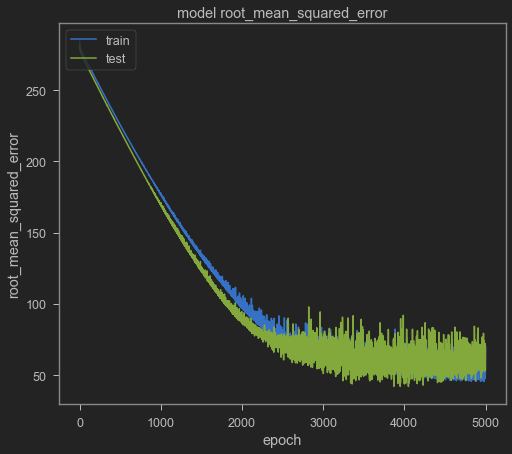

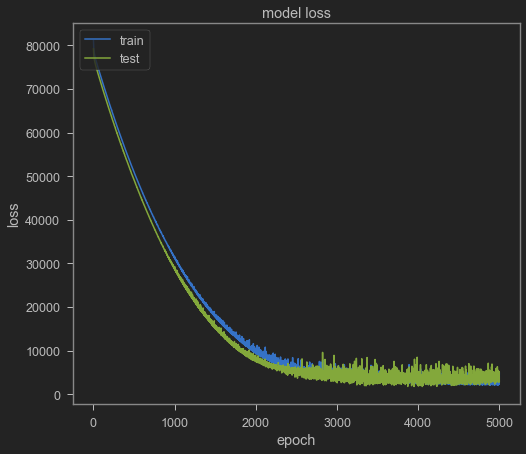

In [12]:
# summarize history for accuracy
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()